# Heart Disease Prediction

### *Introduction*
- The dataset that our group focuses on is the Coronary Artery Heart Disease data which records 14 attributes of patients in four regions: Cleveland, Hungary, Switzerland, and VA Long Beach. The attributes include age, stage of heart disease, blood pressure, and more.
- For our project, we will be focusing on the predictive question:
   *Can we properly diagnose patients with Coronary Artery Heart disease in Cleveland using the patients' age, serum cholesterol, maximum heart rate achieved, resting blood pressure, and old peak?*
- We will aim to produce a classification model that uses five predictor variables that can help us predict whether a patient has heart disease.
- In our analysis for the dataset, we picked Cleveland as our main focus for analysis because different regions can have variations in the chances of getting and factors that cause heart disease. We excluded categorical variables other than heart_disease in the data because they cannot be used for predicting heart disease in classification. We chose age and cholesterol because they are the same predictor variables that the creators of the Heart Disease data set used in their paper, and they are also good indicators for Coronary Artery Heart disease (Detrano, 1989). During a study of 2544 people that went through coronary angiography, “cholesterol levels were associated with an increase in coronary artery occlusion”. As people age, the heart muscle becomes stiffer and less efficient in pumping blood (Strait, 2012). This is one of the reasons cholesterol is chosen. We also choose to use resting blood pressure, old peak, maximum heart rate achieved, and ST depression caused by activity compared to rest. That is because although they were not used as predictors by the creators of the dataset for analysis, only for routine test data collection (Detrano, 1989), we believe that they are also important factors to help with our classification model. With only two predictor variables of age and cholesterol, it may not be enough for classifying heart disease.
- Also, the association between heart disease and cholesterol “held only for the younger men”, (Jacobson, 1992), meaning that as age increases, cholesterol levels become more insignificant in predicting coronary artery heart disease. This is why we need more predictor variables that give our model more information to predict coronary artery heart disease. From the matrix plot we graphed in the next section, it can be seen that all five predictors have some correlation with the patients with heart disease present and absent. Therefore, it is a good idea to use these five variables to increase our model’s accuracy.


In [20]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(GGally)
library(repr)
options(repr.matrix.max.rows = 6)

In [32]:
set.seed(1234)
url <- "https://raw.githubusercontent.com/Jessieec/Group-Proposal/main/heart_disease_uci.csv"
heart_data <- read_csv(url)
print("Heart Disease Data Table")
heart_data

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Heart Disease Data Table"


id  age sex  dataset       cp              trestbps chol fbs  
1   1   63  Male Cleveland     typical angina  145      233   TRUE
2   2   67  Male Cleveland     asymptomatic    160      286  FALSE
3   3   67  Male Cleveland     asymptomatic    120      229  FALSE
⋮   ⋮   ⋮   ⋮    ⋮             ⋮               ⋮        ⋮    ⋮    
918 918 55  Male VA Long Beach asymptomatic    122      223   TRUE
919 919 58  Male VA Long Beach asymptomatic     NA      385   TRUE
920 920 62  Male VA Long Beach atypical angina 120      254  FALSE
    restecg          thalch exang oldpeak slope       ca thal              num
1   lv hypertrophy   150    FALSE 2.3     downsloping 0  fixed defect      0  
2   lv hypertrophy   108     TRUE 1.5     flat        3  normal            2  
3   lv hypertrophy   129     TRUE 2.6     flat        2  reversable defect 1  
⋮   ⋮                ⋮      ⋮     ⋮       ⋮           ⋮  ⋮                 ⋮  
918 st-t abnormality 100    FALSE  0      NA          NA fixed defect      2  
919 lv hypertrophy    NA       NA NA      NA          NA NA                0  
920 lv hypertrophy    93     TRUE  0      NA          NA NA                1

### *Preliminary exploratory data analysis*

In [34]:
set.seed(1234)
heart_data_wrangled <- heart_data |>
    select(age, dataset, trestbps, chol, oldpeak, thalch, num) |>
    rename(region = dataset, heart_disease = num) |>
    filter(region == "Cleveland") |>
    mutate(heart_disease = as_factor(heart_disease)) |>
    mutate(heart_disease = fct_recode(heart_disease, "absent" = "0", "present" = "1", "present" = "2", "present" = "3", "present" = "4"))
    print("Heart Disease Wrangled Data Table")
    
heart_data_wrangled

[1] "Heart Disease Wrangled Data Table"


age region    trestbps chol oldpeak thalch heart_disease
1   63  Cleveland 145      233  2.3     150    absent       
2   67  Cleveland 160      286  1.5     108    present      
3   67  Cleveland 120      229  2.6     129    present      
⋮   ⋮   ⋮         ⋮        ⋮    ⋮       ⋮      ⋮            
302 57  Cleveland 130      236  0       174    present      
303 38  Cleveland 138      175  0       173    absent       
304 28  Cleveland 130      132  0       185    absent

In [35]:
#training data
set.seed(1234)
heart_data_split <- initial_split(heart_data_wrangled, prop = 0.75, strata = heart_disease)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)
print("Heart Disease Trained Data")
heart_data_training

[1] "Heart Disease Trained Data"


age region    trestbps chol oldpeak thalch heart_disease
1   37  Cleveland 130      250  3.5     187    absent       
2   41  Cleveland 130      204  1.4     172    absent       
3   56  Cleveland 120      236  0.8     178    absent       
⋮   ⋮   ⋮         ⋮        ⋮    ⋮       ⋮      ⋮            
225 59  Cleveland 164      176  1.0      90    present      
226 68  Cleveland 144      193  3.4     141    present      
227 57  Cleveland 130      236  0.0     174    present

In [39]:
# mean of selected predictors
set.seed(1234)
heart_data_mean <- summarize(heart_data_training, 
                             age_mean = mean(age),
                             chol_mean = mean(chol), 
                             trestbps_mean = mean(trestbps),
                            oldpeak_mean = mean(oldpeak),
                            thalch_mean = mean(thalch, na.rm = TRUE)) |>
                    pivot_longer(cols = age_mean:thalch_mean,
                                 names_to = "variables",
                                 values_to = "mean")
print("Mean of Predictors")
heart_data_mean

# number of observations for each class
heart_data_observations <- group_by(heart_data_training, heart_disease) |>
    summarize(count = n())
print("Count of Categorical Variable")
heart_data_observations

# rows with missing data
heart_data_missing <- filter(heart_data_training, is.na(thalch) & is.na(trestbps) & is.na(chol) & is.na(heart_disease)) |>
    count()
print("Count of NA Values")
heart_data_missing

[1] "Mean of Predictors"


variables     mean      
1 age_mean       54.806167
2 chol_mean     247.392070
3 trestbps_mean 131.731278
4 oldpeak_mean    1.035683
5 thalch_mean   149.674009

[1] "Count of Categorical Variable"


heart_disease count
1 absent        123  
2 present       104

[1] "Count of NA Values"


n
1 0

- We have summarized our training data into 3 tables. One is for the mean of each of the variables. One is for the count of each of the stages. Since our count for absent and present is similar, we can continue making the model. If one variable had much more counts than the other, then our prediction could be high if our model was good at predicting only one of the variables but not good at predicting the other variable. We do not need to worry about missing data because our missing data count is 0 in our training data. 

In [40]:
#scale the data
set.seed(1234)
recipe <- recipe(heart_disease ~ age + chol + trestbps + thalch + oldpeak, data = heart_data_training) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_disease_scaled <- recipe |>  
                            prep() |> 
                            bake(heart_data_training)
print("Heart Disease Scaled")
heart_disease_scaled

[1] "Heart Disease Scaled"


age       chol       trestbps    thalch     oldpeak     heart_disease
1   -1.921202  0.0484745 -0.09707131 1.6282586   2.0993116  absent       
2   -1.489621 -0.8065437 -0.09707131 0.9739189   0.3103559  absent       
3    0.128809 -0.2117484 -0.65776308 1.2356548  -0.2007743  absent       
⋮   ⋮         ⋮          ⋮           ⋮          ⋮           ⋮            
225 0.4524949 -1.3269895  1.80928072 -2.6031384 -0.03039761 present      
226 1.4235528 -1.0110045  0.68789717 -0.3783832  2.01412320 present      
227 0.2367043 -0.2117484 -0.09707131  1.0611642 -0.88228128 present

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


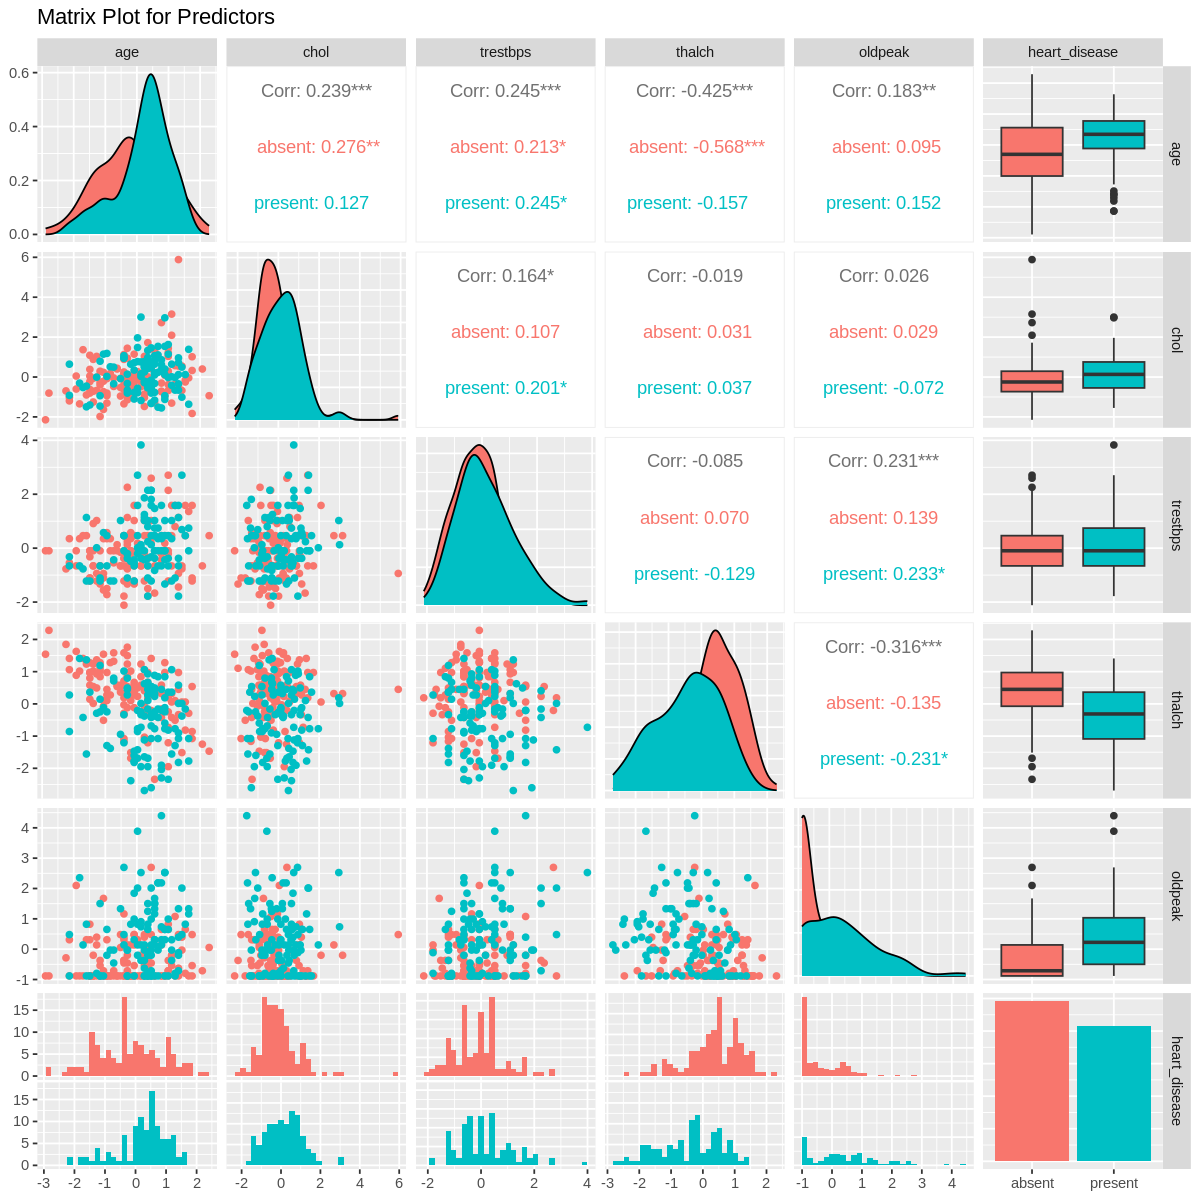

In [42]:
#graph for Age vs. Stage of Heart Disease
set.seed(1234)
options(repr.plot.width = 10, repr.plot.height = 10)
Heart_Disease_Predictors_Plot <- heart_disease_scaled |> select(age:heart_disease) |>
     ggpairs(mapping = aes(color = heart_disease)) +
    ggtitle("Matrix Plot for Predictors")
Heart_Disease_Predictors_Plot

- From each of the five variables plotted against each other, we can see that there is a slight trend of concentration for data points indicating patients with heart disease (present) and patients without heart disease (absent). For example, there are areas on each plot with more concentration of blue points (present) than red points (absent). This means that the five predictors all have some correlation to heart disease.
- However, the groups are not too distinct and many of the scatter plots shown in the matrix plot have groups of red and blue points mixed together. This means that we are most likely not going to get a high accuracy because k-nn classification classifies points based on the closest neighboring points. Without a clear separation between groups, the neighboring points chosen may involve equally distributed amounts of blue and red points. This will cause a potential wrong classification for new data points or patients.

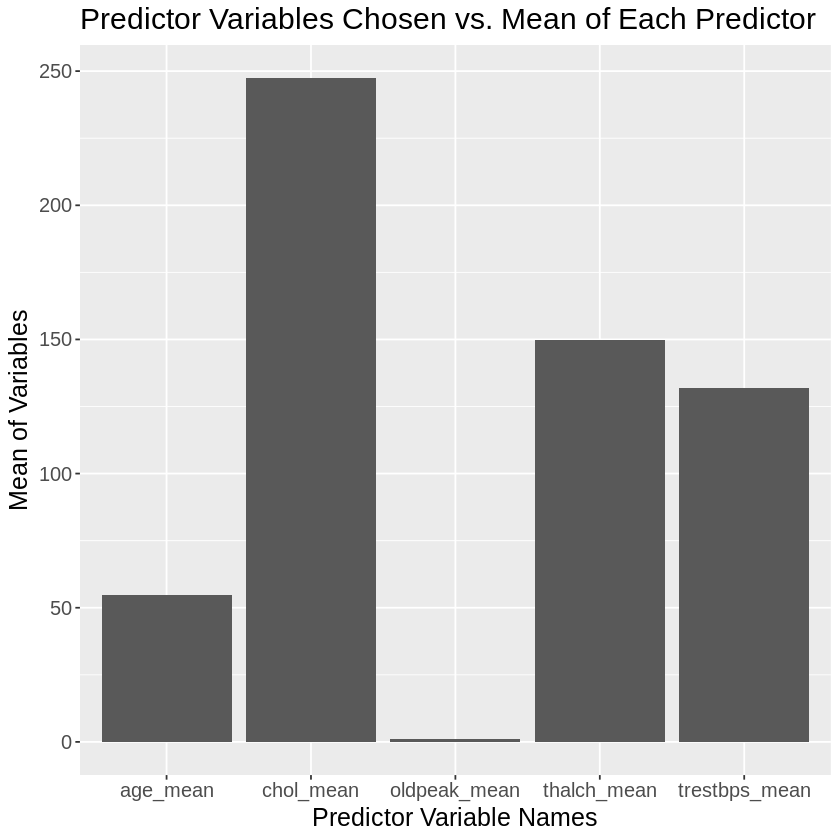

In [43]:
#graph for Mean Data
set.seed(1234)
options(repr.plot.width = 7, repr.plot.height = 7)
heart_data_mean_plot <- heart_data_mean |>
    ggplot(aes(x = variables, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "Predictor Variable Names", y = "Mean of Variables") +
    ggtitle("Predictor Variables Chosen vs. Mean of Each Predictor") +
    theme(text = element_text(size = 15))
heart_data_mean_plot

#### *Note About Oldpeak on the Mean Bar Chart:*
- Since we will be scaling the data later on in our analysis, the oldpeak value being comparably smaller will not be an issue.

### *Method*

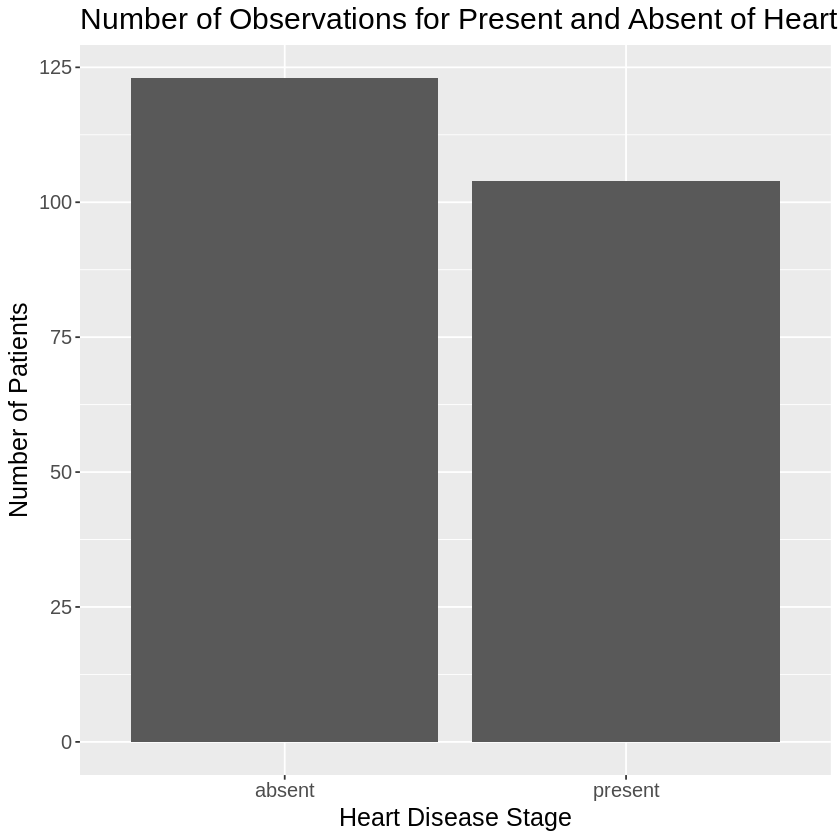

In [44]:
#graph for number of observations
# This section help us visualize the distribution of patients for different stages of heart disease
set.seed(1234)
heart_data_observation_plot <- heart_data_observations |>
    ggplot(aes(x = heart_disease, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Heart Disease Stage", y = "Number of Patients") +
    ggtitle("Number of Observations for Present and Absent of Heart Disease") +
    theme(text = element_text(size = 15))
heart_data_observation_plot

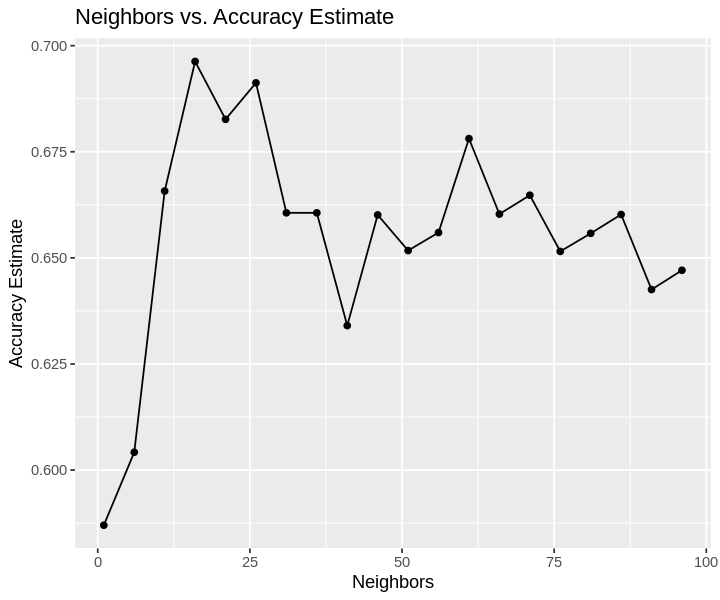

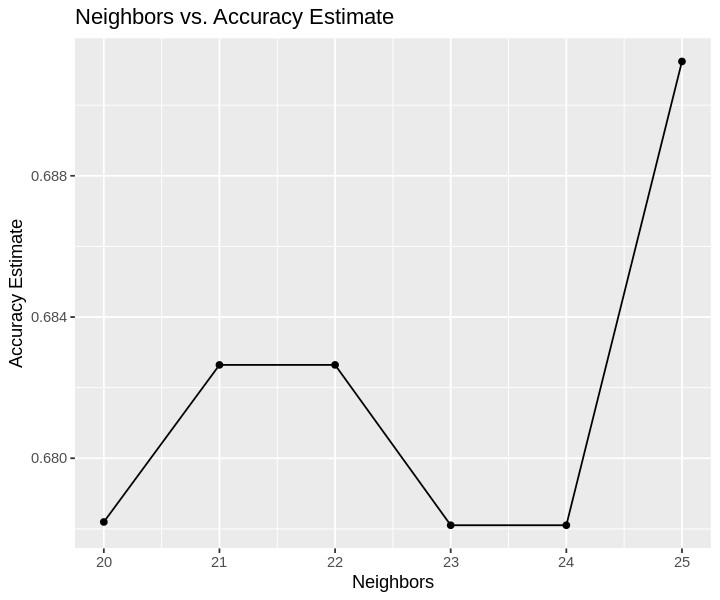

In [63]:
set.seed(1234) 

options(repr.plot.height = 5, repr.plot.width = 6)

heart_vfold <- vfold_cv(data = heart_data_training, v = 5, strata = heart_disease)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_recipe <- recipe(heart_disease ~ age + chol + trestbps + thalch + trestbps, data = heart_data_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

values_1 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_fit_1 <- workflow() |>
                add_model(knn_tune) |>
                add_recipe(heart_recipe) |>
                tune_grid(resamples = heart_vfold, grid = values_1) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot_1 <- ggplot(heart_fit_1, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Neighbors vs. Accuracy Estimate")

cross_val_plot_1

values_2 <- tibble(neighbors = seq(from = 20, to = 25, by = 1))

heart_fit_2 <- workflow() |>
                add_model(knn_tune) |>
                add_recipe(heart_recipe) |>
                tune_grid(resamples = heart_vfold, grid = values_2) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot_2 <- ggplot(heart_fit_2, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Neighbors vs. Accuracy Estimate")

cross_val_plot_2

- We graphed the neighbors from 0 to 100 for the first graph and narrowed the scope on our highest peak for the second graph.
- After testing using the codes below, we found that the best k-neighbors value that gives the highest accuracy estimate is between 21-22. 

In [66]:
set.seed(1234) 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                set_engine("kknn") |>
                set_mode("classification")

heart_final_fit <- workflow() |>
            add_recipe(heart_recipe) |>
            add_model(heart_spec) |>
            fit(data = heart_data_training)

heart_final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3348018
Best kernel: rectangular
Best k: 21

[1] "Accuracy of Model"


.metric  .estimator .estimate
1 accuracy binary     0.6883117

[1] "Precision of Model"


.metric   .estimator .estimate
1 precision binary     0.6666667

[1] "Recall of Model"


.metric .estimator .estimate
1 recall  binary     0.6285714

[1] "Matrix Table"


          Truth
Prediction absent present
   absent      31      13
   present     11      22

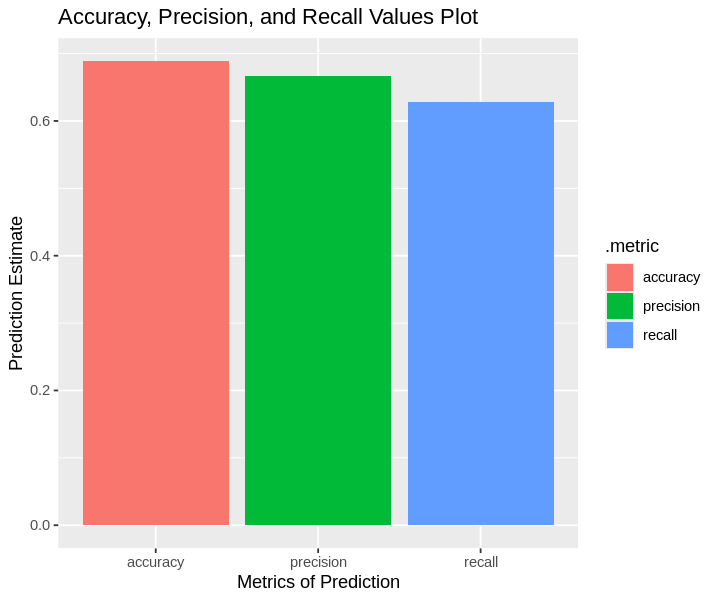

In [67]:
# Set the seed. Don't remove this!
set.seed(1234)

heart_predictions <- heart_final_fit |>
    predict(heart_data_testing) |>
    bind_cols(heart_data_testing)

heart_conf_mat <- heart_predictions |>
    conf_mat(truth = heart_disease, estimate = .pred_class)

heart_metrics <- heart_predictions |>
    metrics(truth = heart_disease, estimate = .pred_class) |>
    filter(.metric == "accuracy")

print("Accuracy of Model")
heart_metrics

precision <- heart_predictions |>
    precision(truth = heart_disease, estimate = .pred_class, event_level = "second")
print("Precision of Model")
precision

recall <- heart_predictions |>
    recall(truth = heart_disease, estimate = .pred_class, event_level = "second")

print("Recall of Model")
recall

print("Matrix Table")
heart_conf_mat

merge <- bind_rows(heart_metrics, precision, recall) 

metrics_bar_plot <- ggplot(merge, aes(x = .metric, y = .estimate, fill = .metric)) + 
                    geom_bar(stat = "identity") + 
                    labs(x = "Metrics of Prediction", y = "Prediction Estimate", color = "Metric of Prediction") + 
                    ggtitle("Accuracy, Precision, and Recall Values Plot")

metrics_bar_plot

# all_metrics_plot <- ggplot(all_metrics, aes(x = sex, y = .estimate, fill = .metric)) +
# geom_bar(stat = "identity", position = "dodge") + 
# labs(fill = "Prediction Metric", x = "Sex", y = "Value", title = "Figure 5: Chart of evaluation metrics on testing sets")
# all_metrics_plot

- Our model has a 69.8% accuracy, which may not be considered high. The recall, which is the number of correct positive predictions over the total positive observations, is 62.9%, a relatively low percentage. For our model, the positive predictions are of the class “present”, and the negative predictions are of the class “absent”. With recall being low, this indicates that our model may not correctly diagnose patients who have heart disease, which might be fatal for people who actually have heart disease and were predicted in the class of “absent”.
- Our model has a precision of 66.7%, which is also not a very high percentage. However, this is less fatal than having a lower recall percentage because it is less fatal for someone without a heart to be diagnosed with heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


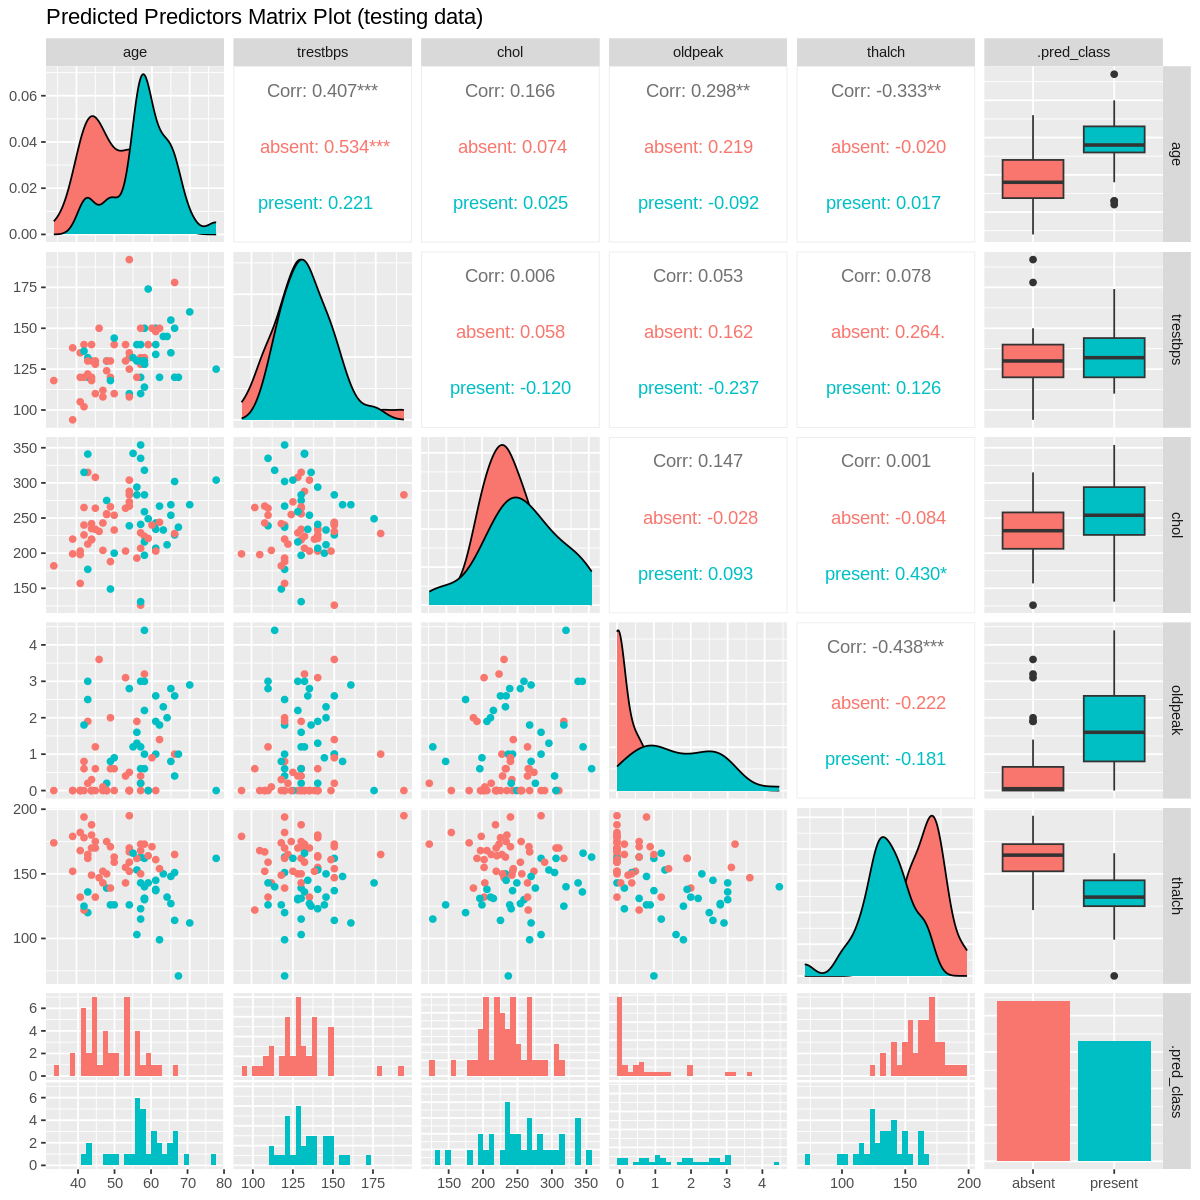

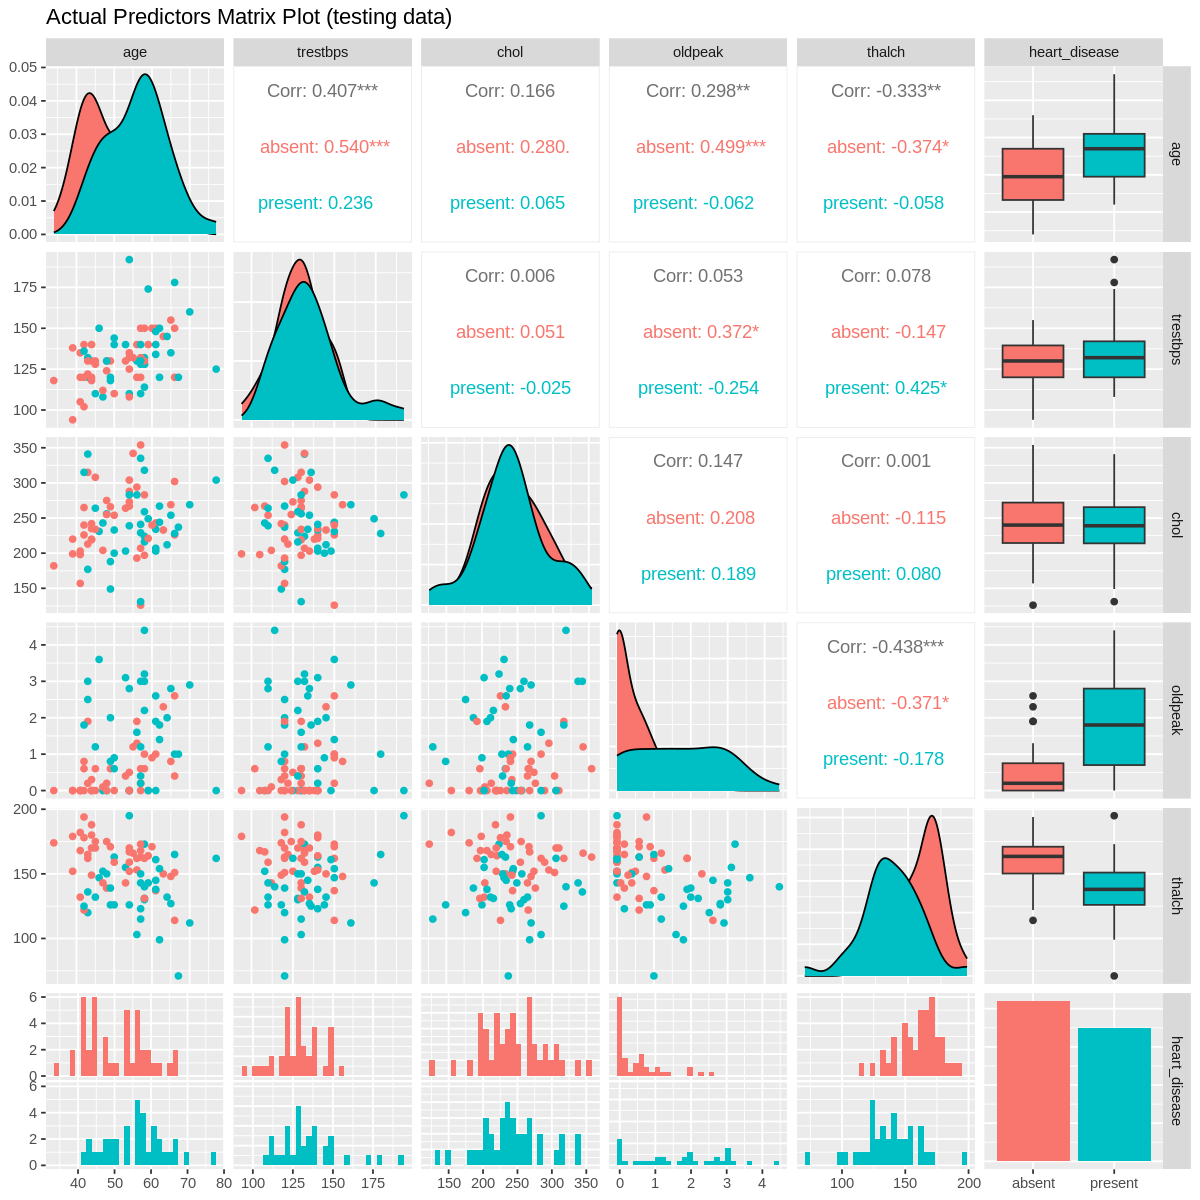

In [50]:
set.seed(1234)
options(repr.plot.width = 10, repr.plot.height = 10)

mnist_predictions_with_labels <- heart_predictions |> 
select(.pred_class) |>
bind_cols(heart_data_testing |> select (heart_disease)) |>
mutate(seq = 1:nrow(heart_predictions)) |>
as.data.frame()

predicted_labels <- mnist_predictions_with_labels |> select(.pred_class)

heart_testing_set <- bind_cols(heart_data_testing, predicted_labels)

#predicted diagnosis on testing data 
predicted_testing_diagnoses_plot <- heart_testing_set |> select(age, trestbps, chol, oldpeak, thalch, .pred_class) |> 
                                    ggpairs(mapping = aes(color = .pred_class)) +
                                    ggtitle("Predicted Predictors Matrix Plot (testing data)")
predicted_testing_diagnoses_plot

#actual diagnosis on testing data 
testing_diagnoses_plot <- heart_testing_set |> select(age, trestbps, chol, oldpeak, thalch, heart_disease) |> 
                          ggpairs(mapping = aes(color = heart_disease)) +
                        ggtitle("Actual Predictors Matrix Plot (testing data)")
testing_diagnoses_plot

# diagnosed_negative_patient <- heart_testing_set |> slice(73) 
# diagnosed_negative_patient

# diagnosed_positive_patient <- heart_testing_set |> slice(4) 
# diagnosed_negative_patient

# matching <- mnist_predictions_with_labels |>
# filter(.pred_class == heart_disease)
# matching

# not_matching <- mnist_predictions_with_labels |>
#      filter(.pred_class != heart_disease)
# not_matching

# actual_testing_diagnoses_plot <- heart_testing_set |> 
#                                      ggplot(aes(x = age, y = trestbps, color = heart_disease)) + 
#                                      geom_point() + 
#                                      labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Actual Diagnosis") + 
#                                      ggtitle("Heart Disease Testing Data Diagnosis Plot")
# actual_testing_diagnoses_plot

# predicted_testing_diagnoses_plot <- heart_testing_set |> 
#                                     ggplot(aes(x = age, y = trestbps, color = .pred_class)) + 
#                                     geom_point() + 
#                                     labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Predicted Diagnosis") + 
#                                     ggtitle("Heart Disease Testing Data Predicted Diagnosis Plot")

# diagnosed_negative_patient <- heart_testing_set |> slice(73) 
# diagnosed_negative_patient


# matching <- mnist_predictions_with_labels |>
# filter(.pred_class == y) |> 
# sample_n(3)
# heart_disease_labels <- heart_data_
# # random patient from our testing data with no heart disease 
# testing_patient_absent <- heart_data_testing |> slice(30)
# testing_patient_absent
# # random patient from our testing data with heart disease 
# testing_patient_present <- heart_data_testing |> slice(4)
# testing_patient_present

- The first graph is the *predicted* diagnosis on our testing data and the second graph is the *actual* diagnosis on our testing data. We can see that the grouping and concentration for the present and absent classes for each predictor of the two matrix plots are similar. For example, if there are more blue points (present) concentrated in one area of the actual diagnosis graph, then there is a corresponding concentration of blue points in the same area in the predicted diagnosis graph. If there are more red points (absent) concentrated in one area of the actual diagnosis graph, then there are more red points in the same area in the predicted diagnosis graph. We can also see from our predicted diagnosis plot that it predicts more data points being absent than present for the testing data, which is shown on the bottom right bar plot. The points on the actual diagnosis graph are more mixed together while the predicted diagnosis graph tends to be more separations in between the blue and red. Because we have a high number for the neighbors chosen, we tend to have bigger generalized groups in the predicted diagnosis graph. 

In [35]:
#pick one patient 

# diagnosed_positive_patient <- heart_testing_set |> slice(4) 
# diagnosed_positive_patient

# predicted_testing_diagnoses_plot <- heart_testing_set |> 
#                                     ggplot(aes(x = age, y = trestbps, color = .pred_class)) + 
#                                     geom_point() + 
#                                     labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Predicted Diagnosis") + 
#                                     ggtitle("Heart Disease Testing Data Predicted Diagnosis Plot")

# actual_testing_diagnoses_plot <- heart_testing_set |> 
#                                      ggplot(aes(x = age, y = trestbps, color = heart_disease)) + 
#                                      geom_point() + 
#                                      labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Actual Diagnosis") + 
#                                      ggtitle("Heart Disease Testing Data Diagnosis Plot")
# actual_testing_diagnoses_plot


Here we plotted our scatter plots from our matrix plots above except we plot testing data instead of training data. 

In [ ]:
# set.seed(1234)

# patient <- tibble(age = 80, chol = 200)

# heart_predict <- predict(heart_final_fit, patient)

# heart_predict

In [ ]:
# heart_data_selected <- heart_data_wrangled |> select(age, chol, heart_disease)
# patient_point <- c(80, 200)
# options(repr.plot.width = 12, repr.plot.height = 8)
# heart_data_selected |>
#     ggplot(aes(x = age, 
#                y = chol, 
#                colour = heart_disease)) +
#         labs(x = "Age (in years)",
#              y = "Cholestoral (in mg/dl)",
#             colour = 'Stage of Heart Disease') +
#         geom_point(size = 2.5) +
#         theme(text = element_text(size = 20)) +
#         annotate("path", 
#                  x=patient_point[1] + 5*cos(seq(0,2*pi,length.out=50)),
#                  y=patient_point[2] + 0.1*sin(seq(0,2*pi,length.out=50))) 

### *Discussion*

- The accuracy rate at a lower percentage is not exactly what we expected to find. Since we took five predictors to predict our model, we expected that the accuracy to be higher, with recall and precision also being high. The result shows that all of these three percentages are in the 60 to 70% range. This indicates that these predictors may not be as relevant to heart disease as we expected them to be. In order to increase accuracy, we may need to look into more predictor variables.
- Since our model is not that accurate with 69.8% accuracy, the prediction of “absent” and “present” of heart disease using our model is not accurate. Therefore, if we use this model in an actual prediction for patients’ heart disease, the inaccurate diagnosis will impact the patients both physically and mentally. If we want to use this model in the future, we need further investigations. For instance, we might consider other predictors apart from the five predictors we are using now in order to increase the accuracy and create less negative impacts for the patients.
- We can also consider the following question for the future: 
Despite our model’s focus on Coronary Artery Disease, can our model accurately predict heart disease stages for other heart diseases of the general public?

#### Reference

- Benfante R, Reed D. Is Elevated Serum Cholesterol Level a Risk Factor for Coronary Heart Disease in the Elderly? JAMA. 1990;263(3):393–396. doi:10.1001/jama.1990.03440030080025  

- Detrano R, Janosi A, Steinbrunn W, Pfisterer M, Schmid JJ, Sandhu S, Guppy KH, Lee S, Froelicher V. International application of a new probability algorithm for the diagnosis of coronary artery disease. Am J Cardiol. 1989 Aug 1;64(5):304-10. doi: 10.1016/0002-9149(89)90524-9. PMID: 2756873. 
